## Проблема экстраполяции в решающих деревьях

Ансамбли решающих деревьев [не способны к эффективной экстраполяции](https://www.youtube.com/watch?v=buXRdy8VJm0&t=1336s). В частности, если в обучающих данных максимальное значение $i$-го признака было равно $x_i^{max}$, а при тестировании модель встретилась с еще большим значением этого признака: $x_i^{test} > x_i^{max}$, то ответ модели не будет зависеть от значения $x_i^{test} - x_i^{max}$. В целом проблема экстраполяции в том, что в областях, где обучающих данных было мало или они вовсе отсутствовали, получаемое решение будет константой или достаточно грубой кусочно-постоянной функцией (см. [habr](https://habr.com/ru/company/ods/blog/645887/), рис. 2).

Человеку, напротив, свойственно продолжать неизвестные зависимости плавной линией, что часто хорошо подтверждается в реальности. Нейронные сети в этом смысле лучше решающих деревьев, поскольку способны к экстраполяции выученных зависимостей.

Для примера возьмем датасет boston housing и сравним экстраполяцию нейронными сетями и решающими деревьями.

In [29]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers, datasets, callbacks

(X, y), (X_test, y_test) = datasets.boston_housing.load_data()

def train_network(activation):
  model = Sequential([
      layers.Dense(1000, activation),
      layers.Dropout(0.5),
      layers.Dense(1000, activation),
      layers.Dropout(0.5),
      layers.Dense(1)])
  model.compile(loss='mse')
  model.history = callbacks.History()
  model.fit(X, y, batch_size=8, epochs=1000, verbose=0,
            validation_data=(X_test, y_test),
            callbacks=callbacks.EarlyStopping(patience=10))
  val_losses = model.history.history['val_loss']
  print(f'Epochs: {len(val_losses)}, val loss: {val_losses[-1]:g}')
  return model

def test_extrapolation(model, examples, range=1):
  fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 4))
  for i, ax in enumerate(axes.flat):
    _min, _max = X[:, i].min(), X[:, i].max()
    delta = _max - _min
    test_range = (_min - delta*range, _max + delta*range)
    test_values = np.linspace(*test_range, num=200)
    for example in examples:
      inputs = np.tile(example, (len(test_values), 1))
      inputs[:, i] = test_values
      predictions = model.predict(inputs).squeeze()
      ax.plot(test_values, predictions)
      ax.axvline(x=_min)
      ax.axvline(x=_max)

Epochs: 54, val loss: 58.861


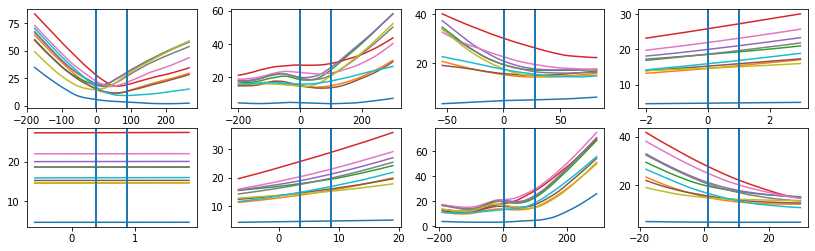

In [30]:
model = train_network('relu')
test_extrapolation(model, X_test[:10], range=2)

Каждый график соответствует одному признаку, вертикальные линии обозначают минимальное и максимальное значение этого признака в обучающем датасете. Каждая линия соответствует одному тестовому примеру, в котором заменено только значение данного признака.

Проверим теперь сети с другой функцией активации и решающие деревья.

Epochs: 37, val loss: 29.3914


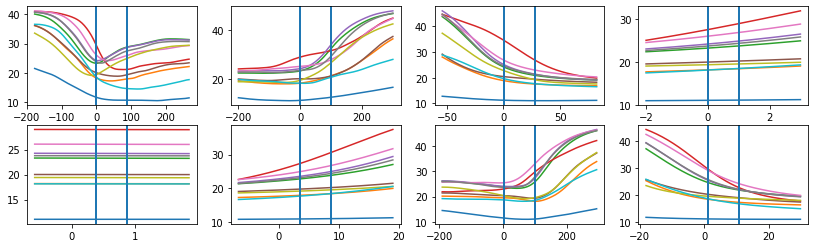

In [31]:
model = train_network('sigmoid')
test_extrapolation(model, X_test[:10], range=2)

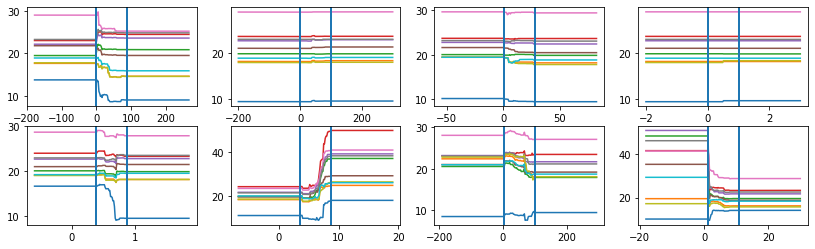

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=1000, max_depth=5).fit(X, y)
test_extrapolation(model, X_test[:10], range=2)

Как можно заметить, функция активации в нейронных сетях влияет на свойства экстраполяции, например, сети с ReLU обычно экстраполируют линейно. Нейрон с ReLU имеет два состояния, и по-видимому переключение состояний нейронов быстро прекращается при выходе за пределы многообразия обучающих данных, и функция становится линейной. В каких-то случаях это может быть неоптимально, например, если зависимость на самом деле логарифмическая.

Решающие деревья всегда экстраполируют константой. Является ли это неразрешимым ограничением, или же есть способ научить решающие деревья экстраполировать?

## Кусочно-линейные решающие деревья

Можно рассмотреть модификацию решающего дерева, в котором каждый лист соответствует не константному значению, а линейной функции от входных признаков. Такой подход рассматривался, например, в [Bishop, 2006]($Pattern Recognition and Machine Learning$), раздел 14.5.1. Однако особенность решающих деревьев в разреженности: если каждый лист будет функцией от всех признаков, то мы получим очень большое число параметров модели и долгое время обучения. Вместо  этого, каждый лист может быть линейной (либо квадратичной и т. д.) функцией лишь от одного признака.

Листья решающего дерева объединяются в пары, и можно дополнительно потребовать, чтобы каждая пара листьев использовала тот же признак, что в последнем разделяющем правиле, и давала в результате непрерывную функцию от этого признака (рис. 1).

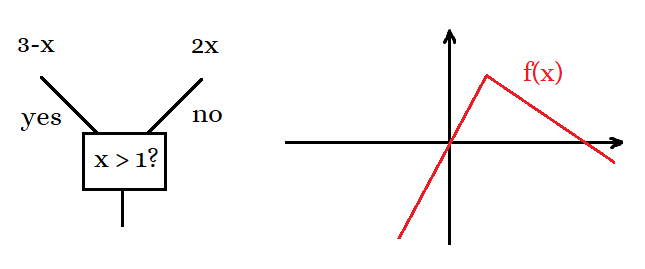
<center>Рис. 1. Кусочно-линейное разделяющее правило.</center>

Однако в таком случае дерево будет линейной функцией лишь от тех признаков, что использовались на последнем уровне (если это решающая таблица - то это лишь один признак). Но наибольшую важность, напротив, имеют те признаки, которые использовались на первых уровнях. Поэтому можно дополнительно потребовать, чтобы на последнем уровне использовался тот же признак, что и на первом уровне. Но это выглядит довольно искусственным решением, и при этом увеличивается сложность обучения.

Возможно ли создать дерево, которое будет кусочно-линейной функцией от всех признаков (кроме категориальных), которые в нем использовались? При этом желательно было бы соблюдение некскольких дополнительных свойств.

Введем следующее определение:

**Кусочно-линейная непрерывная нередуцируемая функция $N$-ного порядка** - это функция $f: \mathbb{R}^N \to \mathbb{R}$ такая, что:
1. Существует разбиение $P_f$ пространства $\mathbb{R}^n$ плоскостями такое, что на каждом участке функция $f$ является линейной. Назовем *прямоугольным разбиением* такое разбиение, что плоскости в нем параллельны координатным осям.
2. Функция $f$ является непрерывной.
3. Функция $f$ не представима в виде суммы функций от меньшего числа переменных (*нередуцируемость*).

Кусочно-линейным ансамблем будем называть сумму конечного числа таких функций. Последнее свойство является ключевым, так как определяет выризительную способность ансамбля (см. [habr](https://habr.com/ru/company/ods/blog/645887/), раздел "Выразительная способность ансамблей решающих деревьев"). Можно дополнительно потребовать, чтобы разбиение $P_f$ содержало каждый признак по одному разу, как в решающих таблицах.

Существуют ли вообще функции, обладающие такими свойствами? Рассмотрим случай $N=2$. Разбиение $P_f$ делит пространство на 4 части; без ограничения общности будем считать, что эти 4 части соответствовуют областям $x_1>0$, $x_1<0$, $x_2>0$, $x_2<0$, и $f(0, 0) = 0$.

Рассмотрим луч $x_1 = 0$, $x_2 > 0$, который проходит между двумя областями. Функция $f$ должна быть линейна на этом луче: $f(0, x_2) = c_1 x_2$. Аналогично, функция линейна на остальных трех лучах, идущих от точки $(0, 0)$ между областями. Этим лучам соответствуют коэффициенты $c_1, c_2, c_3, c_4$ (рис. 2).

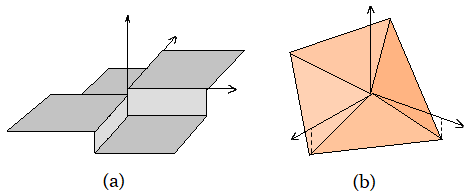

<center>Рис. 2. (a) Решающее дерево, использущее 2 переменные. (b) Кусочно-линейная непрерывная функция от 2 переменных.</center>

Рассмотрим срезы функции $f$, то есть частичное применение функции при двух произвольных значениях $x_1$: $f(x_1^a, \cdot)$, $f(x_1^b, \cdot)$. Обе эти функции будут иметь вид $c2*\text{ReLU}(x_2) + c4*\text{ReLU}(-x_2) + C$, отличаясь только на константу. Отсюда следует, что такая функция раскладывается в сумму функций от одной переменной: $f_1(x_1) + f_2(x_2)$, то есть не удовлетворяет свойству 3. По-видимому, похожим образом можно показать, что функция $f$ не будет удовлетворять свойству 3 и при большем числе областей в разбиении $P_f$.

Отсюда, следует, что вероятно **кусочно-линейных непрерывных нередуцируемых функций с прямоугольным разбиением не существует** (хотя строгое доказательство пока не получено). Если это так, то любая кусочно-линейная функция с прямоугольными областями либо разрывна, либо редуцируема в сумму функций от одной переменной. Тогда кусочно-линейное решающее дерево, в котором разделяющие правила используют по одному признаку, либо дает разрывную функцию, либо редуцируемо и не имеет смысла (так же, как не имеет смысла нейронная сеть с широкими промежуточными слоями без функции активации).

Простым примером кусочно-линейной непрерывной нередуцируемой функции 2-го порядка с **непрямоугольным разбиением** $P_f$ является функция $\text{ReLU}(x_1 + x_2)$. На таких функциях основаны нейронные сети с одним скрытым слоем, являющиеся универсальными аппроксиматорами.

В результате получен набросок доказательства того, что кусочно-линейные решающие деревья, в которых решающие правила используют по одному признаку, вынужденно дают разрывные функции. Впрочем, нет серьезных оснований считать, что это плохо, ведь таковы почти все современные решающие деревья, и при этом они хорошо работают на практике. Но свойство непрерывности, будь оно выполнено, позволило бы эффективнее оптимизировать структуру дерева, в том числе выполнять дообучение градиентным спуском и файг-тюнинг при сдвиге данных.

Это **не означает**, что кусочно-линейные решающие деревья не имеют смысла. Вполне возможно, что они, наоборот, могут оказаться эффективнее стандартных кусочно-постоянных деревьев.

## Оптимизация деревьев градиентным спуском

Ансамбль решающих деревьев можно представить в виде нейронной сети.

Если в ансамбле используется $N$ разных решающих правил, то их можно представить как $N$ нейронов с пороговой функцией активации. Эти нейроны составляют **первый слой** сети (как вариант, можно сразу посчитать значения на них для всех примеров и получить для каждого примера вектор из $N$ признаков).

**Второй слой** сети содержит столько нейронов, сколько суммарно листьев во всех деревьях. Если все деревья имеют глубину $M$, то каждый лист активируется при одновременной активации $M$ определенных нейронов первого слоя. Если от каждого из этих нейронов провести связь с весом $1/M$, и bias нейрона принять равным $-1$, то выполнение всех условий означает величину $0$ на входе нейрона, а невыполнение - величину меньше 0. Нейроны второго слоя могут тоже иметь пороговую функцию активации.

**Третий слой** является выходным и содержит один нейрон (в задаче регрессии), а веса, идущие от второго слоя к третьему, соответствуют значениям на листьях.

Такая нейронная сеть будет эквивалентна исходному ансамблю решающих деревьев. С ней можно провести различные эксперименты, такие как:

1. Заменить все слои, кроме первого, и обучить их заново. Это означает, что исходный ансамбль будет выполнять роль экстрактора бинарных признаков. Признаки можно сгладить, заменив пороговую функцию активации на сигмоиду. Это как раз то, что предлагает Дмитрий Колодезев в ODS Lab.
2. Можно не заменять слои и попробовать дообучить сеть, которая при инициализации была эквивалентна исходному ансамблю деревьев. Для этого можно либо заменить во всех слоях функцию активации на сигмоиду (подобрав коэффициенты сжатия по горизонтали для сигмоид), либо применяя градиент от сигмоиды при обратном распространении ошибки:

In [ ]:
@tf.custom_gradient
def heaviside(x):
  grad = lambda dy: dy * tf.nn.sigmoid(x) * (1 - tf.nn.sigmoid(x))
  return tf.math.sign(x)*0.5 + 0.5, grad

В результате мы получим возможность:
1. Дообучить модель и возможно улучшить ее качество
2. Файн-тюнить модель при сдвиге данных
1. Выполнять инференс теми же методами, что и в нейронных сетях.

Конечно, попытки обучать градиентным спуском модели, похожие на решающие деревья, предпринимались многократно.

> Since decision trees are not differentiable and do not allow gradient optimization, they cannot be used as a component for pipelines trained in the end-to-end fashion. To address this issue, several works ([Hazimeh et al., 2020]($The tree ensemble layer: Differentiability meets conditional computation$); [Kontschieder et al., 2015]($Deep Neural Decision Forests$); [Popov et al., 2020]($Neural Oblivious Decision Ensembles for Deep Learning on Tabular Data$); [Yang et al., 2018]($Deep Neural Decision Trees$)) propose to "smooth" decision functions in the internal tree nodes to make the overall tree function and tree routing differentiable. While the methods of this family can outperform GBDT on some tasks ([Popov et al., 2020]($Neural Oblivious Decision Ensembles for Deep Learning on Tabular Data$)), in our experiments, they do not consistently outperform ResNet. ([Gorishniy et al., 2021]($Revisiting Deep Learning Models for Tabular Data$))

## Почему решающие деревья эффективны?

В настоящее время решающие деревья считаются одними из самых эффективных моделей машинного обучения.

> While deep learning models are more appropriate in fields like image recognition, speech recognition, and natural language processing, tree-based models *consistently outperform standard deep models* on tabular-style datasets where features are individually meaningful and do not have strong multi-scale temporal or spatial structures. ([Lundberg et al., 2019]($Explainable AI for Trees: From Local Explanations to Global Understanding$))

Недавно было проведено исследование ([Gorishniy et al., 2021]($Revisiting Deep Learning Models for Tabular Data$)) со сравнением нейронных сетей и градиентного бустинга. В результате оказалось, что на некоторых задачах лучше работают нейронные сети, а на некоторых градиентный бустинг. Авторы также предлагают архитектуру FT-Transformer, которая хорошо работает на тех задачах, на которых обычные нейронные сети (ResNet) уступают градиентному бустингу.

> ...we have proposed FT-Transformer — a simple adaptation of the Transformer architecture that outperforms other DL solutions on most of the tasks. We have also compared the new baselines with GBDT and demonstrated that GBDT still dominates on some tasks. ([Gorishniy et al., 2021]($Revisiting Deep Learning Models for Tabular Data$))

При этом ансамбли решающих деревьев фиксированной глубины $N$ [не являются](https://habr.com/ru/company/ods/blog/645887/) универсальными аппроксиматорами и представимы как сумма функций не более чем от $N$ переменных.

Можно попробовать обосновать эффективность решающих деревьев следующими гипотезами:

1. **Гипотеза простой зависимости**. Большая часть зависимостей на табличных данных может быть хорошо аппроксимирована суммой функций от небольшого числа переменных. Если это было бы не так, то решающие деревья небольшой глубины не достигали бы хорошей точности на табличных датасетах. Введем для этой гипотезы сокращение: SP-гипотеза (simplicity prior).

2. **Гипотеза условной зависимости**. Некоторые признаки имеют значение лишь при определенных значениях других признаков.

3. **Гипотеза разреженной блок-схемы**. Многие целевые зависимости на табличных данных можно аппроксимировать блок-схемой принятия решения, которая имеет свойство разреженности (на каждом шаге используется лишь 1-2 признака). Эта гипотеза объединяет SP-гипотезу и гипотезу условной зависимости и также имеет связь с consciousness prior ([Bengio, 2017]($The Consciousness Prior$)).

Конечно, это лишь гипотезы: возможно, что эффективность решающих деревьев обусловлена вовсе не этим.

Исследователи еще с XX века задумывались тем, что схема принятия решений часто должна быть разреженной. Для достижения разреженности в линейной регрессии и нейронных сетях иногда применяют l1-регуляризацию (lasso). Поскольку градиент l1-регуляризации никогда не стремится к нулю при ненулевых весах, при выпуклой функции потерь на поздних стадиях оптимизации он приобретает первоочередное значение, в результате многие веса сети сходятся к нулевым значениям (в отличие от L2-регуляризации).

> There has also been much deep and interesting work on the mathematical aspects of the lasso, examining its ability to produce a model with minimal prediction error, and also to recover the true underlying (sparse) model. ([Tibshirani, 2011]($Regression shrinkage and selection via the lasso: a retrospective$))

Нейронные сети в целом не следуют SP-гипотезе. Даже если мы добьемся того, что большая часть весов сети будет равна нулю, сеть в целом скорее всего не будет представима как сумма функций от небольшого числа признаков.

Пример сети с 2 скрытыми слоями по 1000 нейронов, обученной с l1-регуляризацией на датасете boston housing:

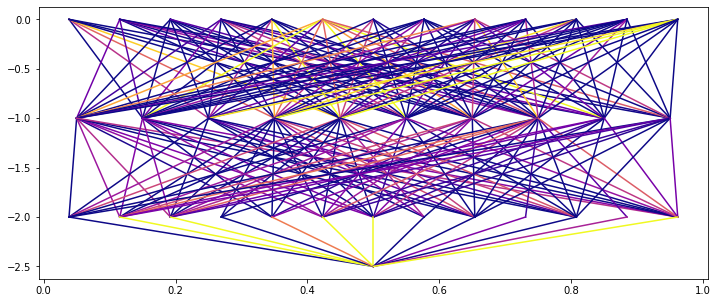

In [3]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers, datasets, callbacks, regularizers, optimizers
import sklearn.preprocessing

(X, y), (X_test, y_test) = datasets.boston_housing.load_data()

scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)
scaler = sklearn.preprocessing.StandardScaler()
y = scaler.fit_transform(y[:, None])[:, 0]
y_test = scaler.transform(y_test[:, None])[:, 0]

model = Sequential([
    layers.Dense(1000, 'relu', kernel_regularizer=regularizers.l1(l1=2e-3)),
    layers.Dense(1000, 'relu', kernel_regularizer=regularizers.l1(l1=8e-3)),
    layers.Dense(1, kernel_regularizer=regularizers.l1(l1=8e-3))])
model.compile(loss='mse', optimizer=optimizers.Adam(1e-4))
model.history = callbacks.History()
model.fit(X, y, batch_size=8, epochs=1000, verbose=0,
         validation_data=(X_test, y_test),
         callbacks=callbacks.EarlyStopping(patience=25))
val_losses = model.history.history['val_loss']
print(f'Epochs: {len(val_losses)}, val loss: {val_losses[-1]:g}')

threshold = 1e-4
plt.figure(figsize=(12, 5))
cmap = plt.get_cmap('plasma')
y_pos = [0, -1, -2, -2.5]

W1, b1 = model.layers[0].get_weights()
W2, b2 = model.layers[1].get_weights()
W3, b3 = model.layers[2].get_weights()
neuron_ids = [
      list(range(X.shape[1])),
      list(np.where((np.abs(W1).max(axis=0) > threshold) \
            & (np.abs(W2).max(axis=1) > threshold))[0]),
      list(np.where((np.abs(W2).max(axis=0) > threshold) \
            & (np.abs(W3).max(axis=1) > threshold))[0]),
      [0]]

for i, layer in enumerate(model.layers):
  W, b = layer.get_weights()
  for from_neuron in range(W.shape[0]):
    for to_neuron in range(W.shape[1]):
      value = W[from_neuron, to_neuron]
      if np.abs(value) > threshold:
        try:
          x1 = (0.5 + neuron_ids[i].index(from_neuron)) / len(neuron_ids[i])
          x2 = (0.5 + neuron_ids[i+1].index(to_neuron)) / len(neuron_ids[i+1])
          plt.plot([x1, x2], [y_pos[i], y_pos[i+1]], color=cmap(value*3))
        except:
          pass
plt.show()

L1-регуляризация уменьшает число нейронов, имеющих ненулевые связи (на рисунке показаны только нейроны, имеющие входные или выходные связи с весами больше 0.001 по модулю), но граф связности между этими нейронами по прежнему остается почти полносвязным, и такая сеть не раскладывается в сумму функций от небольшого числа переменных.

Высокую эффективность при обучении на табличных данных показывают сети архитектуры ResNet (с пробросом связей через несколько слоев).

> First, we reveal that none of the considered DL models can consistently outperform the ResNet-like model. Given its simplicity, it can serve as a strong baseline for future work. ([Gorishniy et al., 2021]($Revisiting Deep Learning Models for Tabular Data$))

Хотя проброс связей не увеличивает выразительную способность сети, он влияет на свойства точки инициализации, от которой начинается процесс оптимизации. Если в MLP-сети точка инициализации представляет собой запутанную функцию от всех переменных, совершенно непохожую на линейную, то в ResNet-сетях точка инициализации уже ближе к линейной функции. Например, в [Gorishniy et al., 2021]($Revisiting Deep Learning Models for Tabular Data$) на табличных данных тестируются сети такого вида:

$\text{Linear} \to \text{ResNetBlock} \to \dots \to \text{ResNetBlock} \to \text{BatchNorm} \to \text{ReLU} \to \text{Linear}$

Где $\text{ResNetBlock}(x) = x + f(x)$, и $f(x)$ имеет следующий вид:

$\text{BatchNorm} \to \text{Linear} \to \text{ReLU} \to \text{Dropout} \to \text{Linear} \to \text{Dropout}$

За счет проброса связей ResNet'ы имеют свойство реализовывать более простые и близкие к линейным функции, чем MLP, что имеет связь с гипотезой простой зависимости, но все же не соответствует ей до конца.

Возможно, недостаточное соответствие нейронных сетей SP-гипотезе является одной из причин того, что решающие деревья часто показывают лучшие результаты на табличных датасетах.

## Реализация SP-гипотезы в нейронных сетях

Можно предложить модификации нейронных сетей, с помощью которых удастся достичь большего соответствия SP-гипотезе. Для этого мы должны каким-то образом изменить пространство поиска решения, то есть заставить сеть предпочитать решения, обладающие желаемыми свойствами.

Самый простой способ явно привести сеть в соответствие SP-гипотезе - это искать ответ в виде суммы ответов подсетей, каждая из которых обрабатывает лишь несколько признаков. Но количество комбинаций признаков может быть очень велико: например, существует $1.2*10^9$ комбинаций 6 из 100 признаков - таким же должно быть и количество подсетей. Значит мы должны рассматривать не все возможные комбинации. есть несколько вариантов выбрать нужные комбинации:

1. Обучить ансамбль решающих деревьев глубиной $N$, разложить его в сумму функций от $N$ признаков и использовать только те комбинации признаков, которые встретились в данном разложении.

2. Обучить набор подсетей, каждая из которых использует только один признак, и затем пробовать добавлять к этим сетям признаки по одному и сохранять изменения, если они привели к росту точности. Так мы получаем жадный алгоритм поиска перебором - такой же, как используется в решающих деревьях. Можно либо неограниченно растить количество подсетей (как в градиентном бустинге), либо ограничиться фиксированным числом подсетей и итеративно добавлять в них признаки. Градиентный бустинг над нейронными сетями был также предложен в [Badirli et al., 2020]($Gradient Boosting Neural Networks: GrowNet$), хотя по существу описанный авторами метод больше напоминает стекинг, либо послойное обучение с суммированием выходов всех слоев.

3. Обучить набор подсетей, каждая из которых использует случайный небольшой набор признаков, и пробовать удалять из этих сетей признаки по одному и сохранять изменения, если они привели к росту точности. Этот метод похож на предыдущий, но действует "в обратную сторону" - через удаление, а не добавление.

4. Обучить набор подсетей, каждая из которых использует случайный небольшой набор признаков, наложив на эти сети сильную L1-регуляризацию весов (или другую подобную ей). Тогда сети сами отбросят ненужные признаки. Далее можно использовать либо сами сети в том виде, в каком они получены, либо использовать наборы признаков, которым в сетях соответствовали ненулевые веса, и обучать новые сети с помощью этих наборов признаков.

5. Использовать комбинацию двух и более перечисленных выше методов.

Предложенные методы очень общие и конкретные реализации могут сильно различаться. Если удастся эффективно реализовать какой-либо из предложенных методов, то решение будет получено в виде ансамбля (суммы) небольших нейронных сетей.

Наконец, еще один подход может заключаться в том, что мы не выбираем явно небольшие наборы признаков, а передаем на вход сети одновременно все признаки (как в обычных нейронных сетях), но при этом находим способ регуляризации, заставляющий сеть предпочитать решения, приблизительно соответствующие SP-гипотезе. Нахождение такого способа регуляризации может быть предметом дальнейших исследований.

Также возможно, что целевую переменную удобнее будет представлять не в виде суммы функций от небольшого числа входных признаков, а в виде суммы функций от небольшого числа скрытых переменных, получаемых линейной комбинацией исходных признаков (например, с помощью PCA или обучаемого линейного слоя).

Остается еще одна проблема, связанная с SP-гипотезой. Допустим, целевая переменная хорошо аппроксимируется суммой функций от 3 переменных. Если мы возьмем экспоненту от целевой переменной (в машинном обучении часто делают подобные преобразования) то сумма станет произведением. Будет ли такое произведение представимо в виде другой суммы (в границах многообразия данных)?

$y \approx \sum\limits_{i, j, k} f_{i, j, k}(x_i, x_j, x_k)$

$\exp y \approx \prod\limits_{i, j, k} \exp f_{i, j, k}(x_i, x_j, x_k) \overset{\large{?}}{\approx} \sum\limits_{i, j, k} g_{i, j, k}(x_i, x_j, x_k)$

Нет оснований считать, что такая аппроксимация всегда будет точна. Вполне возможно, что для каждой задачи существует такое монотонное преобразование целевой переменной, при котором она наилучшим образом представляется в виде суммы функций от небольшого числа входных признаков. Поэтому в нейронную сеть можно добавить обучаемое преобразование целевой переменной. Следуя этой идее, также можно добавить обучаемое преобразование от каждого входного признака:

<img src="assets/scheme.jpg" width="300" align="center">

Преобразования признаков в машинном обучении обычно монотонны, чтобы избежать потери информации. Но в случае обучаемых преобразований можно также разрешить немонотонные преобразования.

Каждое преобразование ($g_i$ и $h$) является обучаемой моделью, и хотелось бы, чтобы эта модель не была излишне сложной. При этом желательна достаточная выразительность этой модели, то есть возможность реализации таких функций, как $Cx$, $ln (x)$, $exp (x)$, $x^2$, и возможно также quantile transformation (приведение выборочного распределения к приблизительно равномерному).